The current solution can hardly identify the trajs that suffered from occlusion. In general, my new design mimics the YOLO to the predict the velocity at each predefined anchor. 

1) Input image: Time-Space diagram, binary image (0/1, 1 dimension), indicating the occupation status on a lane considering the car length (for example, a car with 5m will occupy 10pixels on the time-space diagram). The x-axis represents the time at 0.1 sec resolution, and the y-axis represents the space on the lane at 0.5 meter resolution ranging from 0m (stop bar) to 112m (far side). Input image for the network is 224x224, indicating a time-space diagram with space range of 112m and a time span of 22.4 sec. 

2) Input label: Trajectories coords (time-space, int) on the input image and speed (m/s, float) and corresponding trajectory id (int), indicating the spatial and temperal information of vechicles' front. [traj_id,time,space,velocity], the time and space are converted to the image coordinates. 

3) anchor design: 
Each anchor in the network represents a prediction point in the time-space diagram. We predict three parameters: delta_space, delta_time, v_pred. The delta_space represents the anchor's space difference to the predicted space (difference of y-axis on the image). The delta_time represents the anchor's time difference to the predicted time (difference of x-axis on the image). v_pred represents the anhor's predicted speed according to the visual feature extracted. 

4) loss function:
For loss function calculation, we first infer the actual predicted coord (anchor_time + delta_time ,anchor_space + delta_space) and predicted speed v_pred, and find the nearest label point. First we calculate the speed loss, which is the difference between the prediction speed and the speed of nearest label point. Seconda, we calculate the location loss, which is the distance difference between the pred point and label point. You may also identify other loss like focal loss that may help to improve the detection accuracy. 

5) backbone
Due to we are working on binary image, we may use some light weight backbone. 


In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
# Custom Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F


class TimeSpaceDataset(Dataset):
    def __init__(self, image_path,label_path, transform=None):
        self.image_path = image_path
        self.label_path = label_path
        image_list = os.listdir(image_path)
        label_list = os.listdir(label_path)
        self.image_paths = [os.path.join(image_path, image) for image in image_list]
        self.label_paths = [os.path.join(label_path, label) for label in label_list]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path, label_path = self.image_paths[idx], self.label_paths[idx]
        image = Image.open(image_path)
        # labels are 4 columns:  [traj_id,time,space,velocity]
        labels = np.loadtxt(label_path, delimiter=' ')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels, dtype=torch.float32)
    
def collate_fn(batch):
    # Separate images and labels
    images, labels = zip(*batch)
    
    # Stack images
    images = torch.stack(images, 0)
    
    # Process labels
    max_labels = max(label.size(0) for label in labels)
    
    # Pad labels to have the same length
    padded_labels = []
    mask = []
    for label in labels:
        pad_length = max_labels - label.size(0)
        padded_label = torch.cat([label, torch.zeros(pad_length, 4)], dim=0)
        padded_labels.append(padded_label)
        
        # Create mask: 1 for real data, 0 for padding
        label_mask = torch.cat([torch.ones(label.size(0)), torch.zeros(pad_length)], dim=0)
        mask.append(label_mask)
    
    # Stack padded labels and masks
    padded_labels = torch.stack(padded_labels, 0)
    mask = torch.stack(mask, 0)
    
    return images, padded_labels, mask

class AsymmetricConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride_y=2, stride_x=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d((stride_y, stride_x))

    def forward(self, x):
        return self.pool(self.relu(self.bn(self.conv(x))))

class TrajectoryDetectionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            AsymmetricConvBlock(1, 16, stride_y=2, stride_x=2),    # 224x224 -> 112x112
            AsymmetricConvBlock(16, 32, stride_y=2, stride_x=2),   # 112x112 -> 56x56
            AsymmetricConvBlock(32, 64, stride_y=1, stride_x=2),   # 56x56 -> 56x28
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.regression_head = nn.Conv2d(256, 4, 1)  # 5 = offset_x, offset_y, v_pres, v_next and estimate confidence
    def forward(self, x):
        features = self.features(x)
        output = self.regression_head(features)
        return output.permute(0, 2, 3, 1)  # [batch, 56, 28, 4]

class TrajectoryLoss(nn.Module):
    def __init__(self, lambda_coord=2.0, lambda_speed=1.0, lambda_noobj=0.5):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_speed = lambda_speed
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target, mask, anchors):
        """
        predictions: tensor of shape [batch_size, 56, 28, 4] 
                     (delta_time, delta_space, velocity, confidence)
        labels: list of tensors, each of shape [num_labels, 4] 
                (time, space, velocity, traj_id)
        """
        # width = 28, height = 56 
# [traj_id,time,space,velocity]
        pred_deltas  = predictions[...,:2]  # [batch, height, width, 2]
        pred_velocity = predictions[..., 2] # [batch, height, width]
        pred_confidence = predictions[..., 3] # [batch, height, width]
        pred_coords = anchors + pred_deltas # [batch, height, width, 2]
        total_loc_loss = 0
        total_speed_loss = 0
        total_obj_loss = 0
        total_noobj_loss = 0
        for batch in range(batch_size):
            # mask = [num_labels], 0 for padding, 1 for real data
            target_ = target[batch][mask[batch] == 1] # [num_labels, 4]
            label_locs = target_[...,1:3] # [num_labels, 2]
            label_velocity = target_[..., 3] # [num_labels]
            # [height*width, num_labels]
            loc_error = torch.sum(torch.abs((label_locs.view(-1 , 2) - pred_coords[batch].view(-1, 2).unsqueeze(1))),dim=-1) 
            speed_error = torch.abs(pred_velocity[batch].view(-1,1) - label_velocity.unsqueeze(0))
            weights = F.softmax(-loc_error / 1,dim=-1) # [height*width, num_labels] 

            obj_mask = (loc_error < 6).sum(dim = 1) > 1 # [height*width]
            noobj_mask = ~obj_mask

            noobj_loss = lambda_noobj * (pred_confidence[batch].view(-1,1)[noobj_mask] ** 2).sum()
            # Labels that are closer (have smaller distances) will have larger weights and thus contribute more to the loss. 
            loc_loss = lambda_coord * (weights * (loc_error / 448) **2).sum()
            speed_loss = lambda_speed * (weights * (speed_error / 30) **2).sum()
            obj_loss =  (1 - pred_confidence[batch].view(-1,1)[obj_mask]**2).sum()
            total_loc_loss += loc_loss
            total_speed_loss += speed_loss
            total_obj_loss += obj_loss
            total_noobj_loss += noobj_loss

        total_loss = (total_loc_loss + total_speed_loss + total_obj_loss + total_noobj_loss) / batch_size

        return 

In [523]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create datasets
train_dataset = TimeSpaceDataset(r'D:\TimeSpaceDiagramDataset\train\images', r'D:\TimeSpaceDiagramDataset\train\labels', transform=transform)
val_dataset = TimeSpaceDataset(r'D:\TimeSpaceDiagramDataset\val\images', r'D:\TimeSpaceDiagramDataset\val\labels', transform=transform)
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False,collate_fn=collate_fn)

In [524]:
model = TrajectoryDetectionNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
height = 56
width = 28
anchors = torch.zeros((height, width, 2))
anchors[..., 0] = torch.arange(0, height).view(-1, 1).expand(height, width).float() + 0.5
anchors[..., 1] = torch.arange(0, width).view(1, -1).expand(height, width).float() + 0.5
anchors[..., 0] = 224 * anchors[..., 0] / height
anchors[..., 1] = 224 * anchors[..., 1] / width 
anchors = anchors.to(device) # [height, width, 2]
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [525]:
for batch_idx, (data, target, mask) in enumerate(train_dataloader):
    data, target, mask = data.to(device), target.to(device), mask.to(device)
    optimizer.zero_grad()
    predictions = model(data)
    break

In [588]:
batch_size, height, width, _ = predictions.shape
# Generate anchor grid and corresponding anchor center
anchors = torch.zeros((height, width, 2))
anchors[..., 0] = torch.arange(0, height).view(-1, 1).expand(height, width).float() + 0.5
anchors[..., 1] = torch.arange(0, width).view(1, -1).expand(height, width).float() + 0.5
anchors[..., 0] = 224 * anchors[..., 0] / height
anchors[..., 1] = 224 * anchors[..., 1] / width 
anchors = anchors.to(device) # [height, width, 2]
lambda_coord = 2
lambda_speed = 1
lambda_noobj = 0.5


# width = 28, height = 56 
# [traj_id,time,space,velocity]
pred_deltas  = predictions[...,:2]  # [batch, height, width, 2]
pred_velocity = predictions[..., 2] # [batch, height, width]
pred_confidence = predictions[..., 3] # [batch, height, width]
pred_coords = anchors + pred_deltas # [batch, height, width, 2]
total_loc_loss = 0
total_speed_loss = 0
total_obj_loss = 0
total_noobj_loss = 0
for batch in range(batch_size):
    # mask = [num_labels], 0 for padding, 1 for real data
    target_ = target[batch][mask[batch] == 1] # [num_labels, 4]
    label_locs = target_[...,1:3] # [num_labels, 2]
    label_velocity = target_[..., 3] # [num_labels]
    # [height*width, num_labels]
    loc_error = torch.sum(torch.abs((label_locs.view(-1 , 2) - pred_coords[batch].view(-1, 2).unsqueeze(1))),dim=-1) 
    speed_error = torch.abs(pred_velocity[batch].view(-1,1) - label_velocity.unsqueeze(0))
    weights = F.softmax(-loc_error / 1,dim=-1) # [height*width, num_labels] 

    obj_mask = (loc_error < 6).sum(dim = 1) > 1 # [height*width]
    noobj_mask = ~obj_mask

    noobj_loss = lambda_noobj * (pred_confidence[batch].view(-1,1)[noobj_mask] ** 2).sum()
    # Labels that are closer (have smaller distances) will have larger weights and thus contribute more to the loss. 
    loc_loss = lambda_coord * (weights * (loc_error / 448) **2).sum()
    speed_loss = lambda_speed * (weights * (speed_error / 30) **2).sum()
    obj_loss =  (1 - pred_confidence[batch].view(-1,1)[obj_mask]**2).sum()
    total_loc_loss += loc_loss
    total_speed_loss += speed_loss
    total_obj_loss += obj_loss
    total_noobj_loss += noobj_loss

total_loss = (total_loc_loss + total_speed_loss + total_obj_loss + total_noobj_loss) / batch_size




    


In [589]:
total_loss

tensor(440.1803, device='cuda:0', grad_fn=<DivBackward0>)

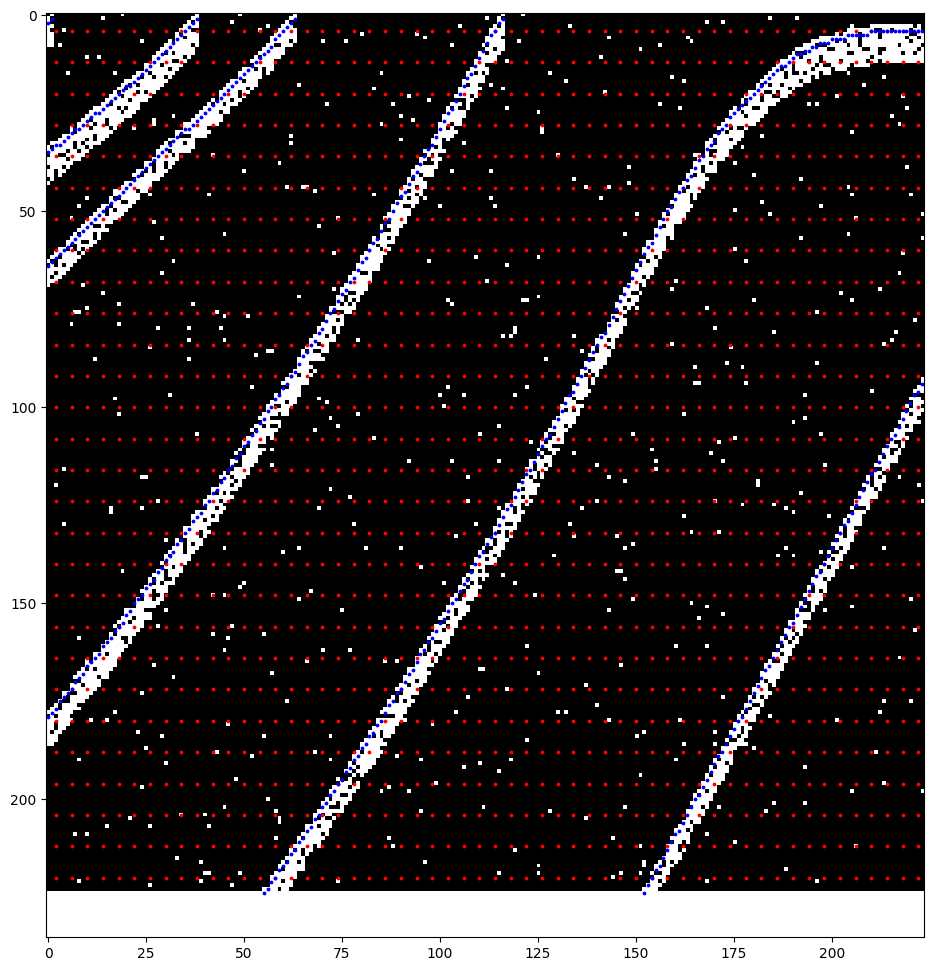

In [207]:
# plot the predicted coordinates and anchors
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.imshow(data[0, 0].cpu().numpy(), cmap='gray')
plt.scatter((anchors[..., 0].cpu().numpy()/56) * 224, (anchors[..., 1].cpu().numpy()/28) * 224, s=3, c='r')
plt.scatter(target[0][:,1].cpu().numpy(), 224 - target[0][:,2].cpu().numpy(), c='b', s=3)

# plot trajectory
plt.show()

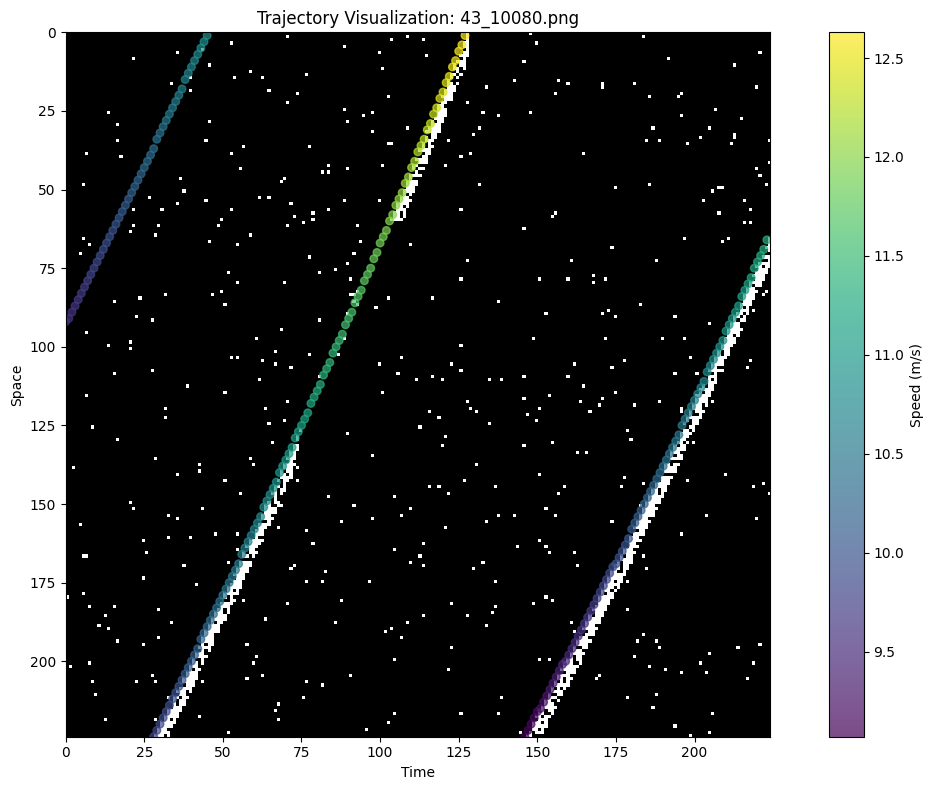

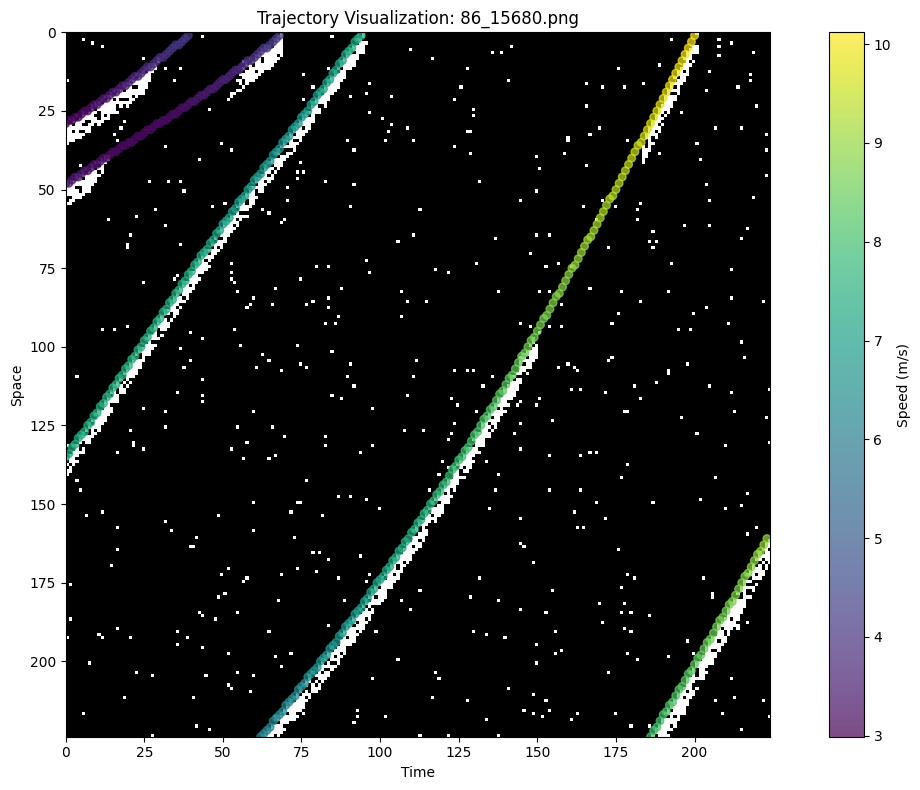

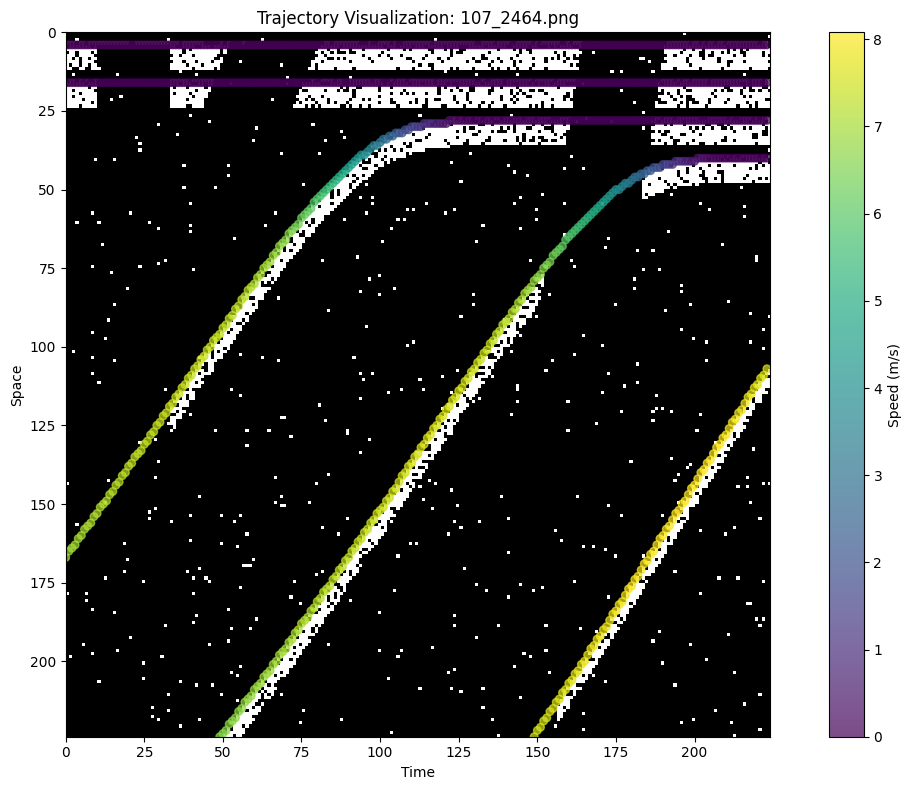

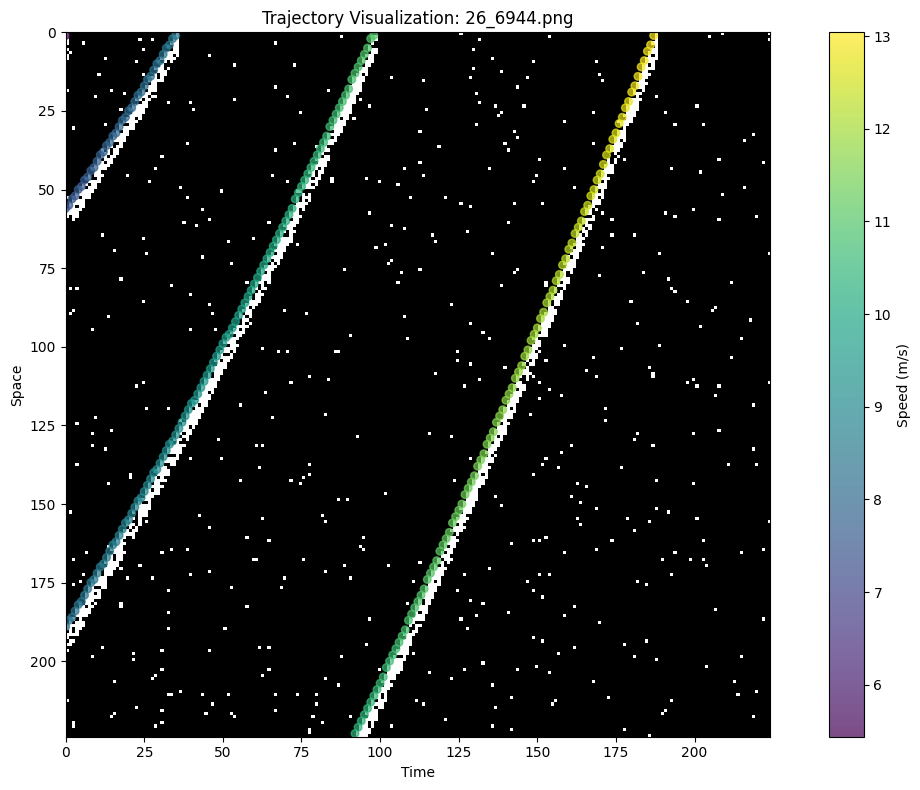

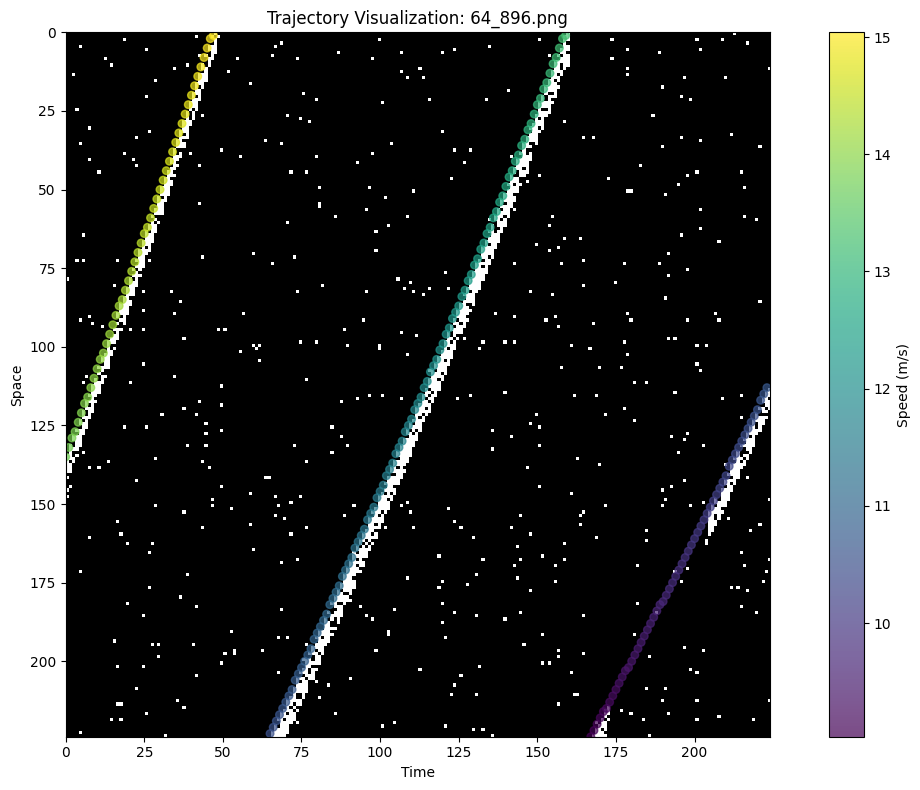

In [49]:

def visualize_data(image_dir, label_dir, num_samples=5):
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    
    # Randomly select samples
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for img_file in selected_files:
        # Load image
        img_path = os.path.join(image_dir, img_file)
        image = np.array(Image.open(img_path).convert('L'))
        
        # Load corresponding label
        label_path = os.path.join(label_dir, img_file.replace('.png', '.txt'))
        trajectory_data = np.loadtxt(label_path, delimiter=' ')
        
        # Extract t, x, and speed from trajectory data
        t = trajectory_data[:, 0] 
        x = trajectory_data[:, 1] 
        speed = trajectory_data[:, 2]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Display the image
        ax.imshow(image, cmap='gray', extent=[0, 224, 224, 0])  # Flip y-axis to match image coordinates
        
        # Plot trajectory points
        scatter = ax.scatter(t, 224 - x, c=speed, cmap='viridis', s=30, alpha=0.7)
        
        # Colorbar for speed
        cbar = plt.colorbar(scatter)
        cbar.set_label('Speed (m/s)')
        
        # Set labels and title
        ax.set_xlabel('Time')
        ax.set_ylabel('Space')
        ax.set_title(f'Trajectory Visualization: {img_file}')
        
        # Show plot
        plt.tight_layout()
        plt.show()

# Usage
image_dir = r'D:\TimeSpaceDiagramDataset\train\images'
label_dir = r'D:\TimeSpaceDiagramDataset\train\labels'
visualize_data(image_dir, label_dir, num_samples=5)